In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from IPython.display import clear_output
import time

low_memory = False

# Read csv into pandas dataframe
df = pd.read_csv('train.csv')

/Users/shonepatil/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [26]:
class Player:
    LBF = 200000 # Pound force attribute for each player used in calculating acceleration
    MAXIMUM_SPEED = 9.0#10.7556 # Yards/Sec
    
    # Create player object with attributes that can be mutated for player movement
    def __init__(self, player_row, increment):
        self.time = 0
        self.increment = increment
        self.play_ID = player_row['PlayId']
        self.play_direct = player_row['PlayDirection']
        self.x = player_row['X']
        self.y = player_row['Y']
        self.target_x = None
        self.target_y = None
        self.speed = player_row['S']
        self.accel = player_row['A'] # yd/s^2
        self.orient = player_row['Orientation']
        self.direct = player_row['Dir']
        if self.direct > 270:
            self.direct_rad = math.radians(360 - (self.direct - 90))
        else:
            self.direct_rad = math.radians(-(self.direct - 90))
        self.ID = player_row['NflId']
        self.rush_ID = player_row['NflIdRusher']
        self.weight = player_row['PlayerWeight'] # pounds
        self.position = player_row['Position']
        self.v = np.array([self.speed * math.cos(self.direct_rad), self.speed * math.sin(self.direct_rad)])
        self.a = np.array([self.accel * math.cos(self.direct_rad), self.accel * math.sin(self.direct_rad)])
        self.new_accel = Player.LBF / (32.174 * self.weight * 3) # yd/s^2 with proper conversions
        self.tackle_attempted = False
        self.tackled = False
        if player_row['Team'] == 'home':
            self.team = player_row['HomeTeamAbbr']
        else:
            self.team = player_row['VisitorTeamAbbr']
        if self.team == player_row['PossessionTeam']:
            self.side = 'O'
        else:
            self.side = 'D'
        if self.isRusher(): # If the player is the rusher
            self.color = 'Orange' 
            if self.play_direct == 'left': # set target location to run towards if left
                self.target_x = 10
                self.target_y = self.y
            else:                          # set target location to run towards if right
                self.target_x = 110
                self.target_y = self.y
        elif self.side == 'O': # If the player is on offense
            self.color = 'Blue'
            if self.play_direct == 'left': # set target location to run towards if left
                self.target_x = 10
                self.target_y = self.y
            else:                          # set target location to run towards if right
                self.target_x = 110
                self.target_y = self.y
        else: # If the player is on defense
            self.color = 'Red'
            self.target_x = None
            self.target_y = None
            
    # Update player's x, y, speed, acceleration, direction, and orientation using target_x and target_y
    def update(self):
        if self.time < 0.7: # This value is how long(seconds) someone runs in a direction before pursuing target

            self.x += self.v[0] * self.increment
            self.y += self.v[1] * self.increment
            self.v += self.a * self.increment
            s = np.linalg.norm(self.v)
            self.v /= s
            self.v *= min(s, self.MAXIMUM_SPEED)

#             print('self.v: ' + str(self.v))
            
        else:
            
            self.a = np.array([self.target_x - self.x, self.target_y - self.y])
            a = np.linalg.norm(self.a)
            self.a /= a
            self.a *= self.new_accel
            
            self.v += self.a * self.increment
            s = np.linalg.norm(self.v)
            self.v /= s
            self.v *= min(s, self.MAXIMUM_SPEED)
            
            self.x += self.v[0] * self.increment
            self.y += self.v[1] * self.increment
            
#             print('self.v: ' + str(self.v))
            
        self.time += self.increment
        
    # Update player's target point to run towards
    def set_target(self, rusher = None, defense = None):
        if rusher == None:
            if self.isRusher(): # Rusher's adjustment
                self.target_y = self.y
                
                in_path = True
                count = 0
                while (in_path):
                    y_offset = []
                    temp_y = self.target_y
                    for player in defense:
                        if self.play_direct == 'left':
                            curr_dist = self.x - player.x
                        else:
                            curr_dist = player.x - self.x
                        if curr_dist < 5 and curr_dist > 0:
                            slope = (self.target_y - self.y) / (self.target_x - self.x)
                            intercept = self.y - slope * self.x
                            A = slope
                            B = -1
                            C = intercept
                            dist_to_path = abs(A * player.x + B * player.y + C) / math.sqrt(A**2 + B**2)
                            if dist_to_path < 0.7:
                                y_offset.append(player)
                    count += 1
                
                    if len(y_offset) > 0 and count < 10:
                        if self.v[1] < 0:
                            self.target_y -= 6.0
                        else:
                            self.target_y += 6.0
                    else:
                        in_path = False
                
            else: # Offense adjustment
                dist = 1000
                for player in defense:
                    if self.position == 'QB': # QB doesn't block
                        continue
                    curr_dist = np.linalg.norm(np.array([player.x - self.x, player.y - self.y]))
                    if curr_dist < dist:
                        dist = curr_dist
                        self.target_x = player.x
                        self.target_y = player.y

        else: # Defense adjustment
            if self.play_direct == 'left':
                self.target_x = rusher.x - 7.2
            else:
                self.target_x = rusher.x + 7.2
            self.target_y = rusher.y
        
    # Simulate player's attempt to tackle the rusher
    def tackle(self, rusher):
        
        tkl_score = self.weight / (self.weight + rusher.weight) # Weight based probability to tackle
        
        outcome = np.random.choice(np.arange(0, 2), p=[1 - tkl_score, tkl_score])
        
        if outcome == 1:
            rusher.tackled = True
        else:
            slow_factor = np.random.choice(np.arange(0,3)) # Randomize slow
            
            rusher.v *= (0.6 + slow_factor * 0.1) # slow down rusher
        
        self.tackle_attempted = True
        
    # Check if this is rusher
    def isRusher(self):
        return self.ID == self.rush_ID
    

In [14]:
pd.set_option('display.max_columns', None)
df[df['PlayId'] == 20170907000395]#20181230154157 20170907000118 20170907000395 20170910003296

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
88,2017090700,20170907000395,away,29.51,27.27,1.05,2.07,0.08,351.17,30.63,2506340,Alex Smith,11,2017,25,1,12:08:00,KC,1,10,KC,7,0,2557917,SHOTGUN,"1 RB, 3 TE, 1 WR",7.0,"3 DL, 2 LB, 6 DB",right,2017-09-08T00:53:14.000Z,2017-09-08T00:53:13.000Z,7,6-4,213,05/07/1984,Utah,QB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
89,2017090700,20170907000395,away,33.19,22.01,2.29,1.27,0.20,39.51,183.24,2532945,Mitchell Schwartz,71,2017,25,1,12:08:00,KC,1,10,KC,7,0,2557917,SHOTGUN,"1 RB, 3 TE, 1 WR",7.0,"3 DL, 2 LB, 6 DB",right,2017-09-08T00:53:14.000Z,2017-09-08T00:53:13.000Z,7,6-5,320,06/08/1989,California,T,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
90,2017090700,20170907000395,away,33.34,27.69,3.26,1.77,0.43,25.50,177.02,2539213,Eric Fisher,72,2017,25,1,12:08:00,KC,1,10,KC,7,0,2557917,SHOTGUN,"1 RB, 3 TE, 1 WR",7.0,"3 DL, 2 LB, 6 DB",right,2017-09-08T00:53:14.000Z,2017-09-08T00:53:13.000Z,7,6-7,315,01/05/1991,Central Michigan,T,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
91,2017090700,20170907000395,away,31.36,34.73,3.54,2.25,0.41,1.01,341.78,2540258,Travis Kelce,87,2017,25,1,12:08:00,KC,1,10,KC,7,0,2557917,SHOTGUN,"1 RB, 3 TE, 1 WR",7.0,"3 DL, 2 LB, 6 DB",right,2017-09-08T00:53:14.000Z,2017-09-08T00:53:13.000Z,7,6-5,260,10/05/1989,Cincinnati,TE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
92,2017090700,20170907000395,away,34.25,35.99,1.69,0.48,0.32,6.72,32.13,2541187,Demetrius Harris,84,2017,25,1,12:08:00,KC,1,10,KC,7,0,2557917,SHOTGUN,"1 RB, 3 TE, 1 WR",7.0,"3 DL, 2 LB, 6 DB",right,2017-09-08T00:53:14.000Z,2017-09-08T00:53:13.000Z,7,6-7,230,07/29/1991,Wisconsin-Milwaukee,TE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
93,2017090700,20170907000395,away,33.61,23.61,2.89,1.41,0.28,19.07,178.21,2543816,Laurent Duvernay-Tardif,76,2017,25,1,12:08:00,KC,1,10,KC,7,0,2557917,SHOTGUN,"1 RB, 3 TE, 1 WR",7.0,"3 DL, 2 LB, 6 DB",right,2017-09-08T00:53:14.000Z,2017-09-08T00:53:13.000Z,7,6-5,321,02/11/1991,McGill,G,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
94,2017090700,20170907000395,away,35.07,26.40,3.41,1.79,0.39,1.03,159.88,2550606,Bryan Witzmann,70,2017,25,1,12:08:00,KC,1,10,KC,7,0,2557917,SHOTGUN,"1 RB, 3 TE, 1 WR",7.0,"3 DL, 2 LB, 6 DB",right,2017-09-08T00:53:14.000Z,2017-09-08T00:53:13.000Z,7,6-7,320,06/16/1990,South Dakota State,T,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
95,2017090700,20170907000395,away,36.19,10.91,1.54,1.14,0.29,341.17,90.11,2552652,Chris Conley,17,2017,25,1,12:08:00,KC,1,10,KC,7,0,2557917,SHOTGUN,"1 RB, 3 TE, 1 WR",7.0,"3 DL, 2 LB, 6 DB",right,2017-09-08T00:53:14.000Z,2017-09-08T00:53:13.000Z,7,6-3,205,10/25/1992,Georgia,WR,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
96,2017090700,20170907000395,away,34.18,24.54,2.96,1.64,0.31,64.39,172.91,2552668,Mitch Morse,61,2017,25,1,12:08:00,KC,1,10,KC,7,0,2557917,SHOTGUN,"1 RB, 3 TE, 1 WR",7.0,"3 DL, 2 LB, 6 DB",right,2017-09-08T00:53:14.000Z,2017-09-08T00:53:13.000Z,7,6-6,305,04/21/1992,Missouri,C,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
97,2017090700,20170907000395,away,33.80,37.41,2.56,1.47,0.49,352.54,43.82,2554630,Ross Travis,88,2017,25,1,12:08:00,KC,1

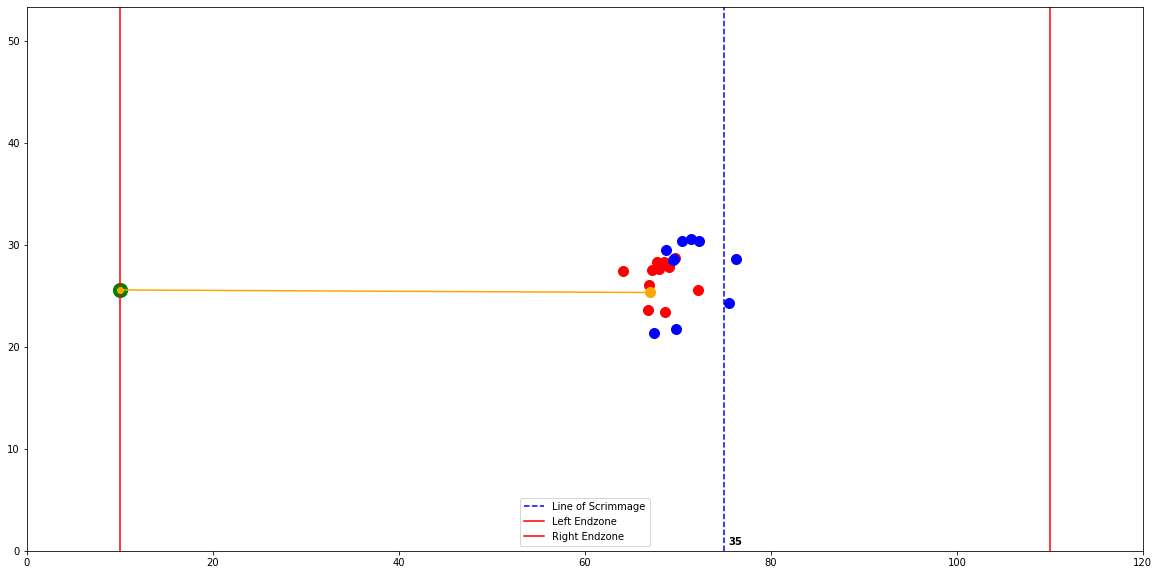

Yards Gained: 7.9581816462047215


In [27]:
class Play:
    def __init__(self, play_ID, increment):
        self.field_set = False
        self.increment = increment
        self.play_ID = play_ID
        self.players_df = df[df['PlayId'] == play_ID]
        self.players_list = []
        self.yards = 0
        
        self.rush_index = 0
        self.count = 0
        for row in self.players_df.iterrows():
            self.count += 1
            if row[1]['NflId'] == row[1]['NflIdRusher']:
                self.rush_index = self.count
                self.rusher = Player(row[1], increment)
                self.pos_team = row[1]['PossessionTeam']
                self.field_pos = row[1]['FieldPosition']
            else:
                self.players_list.append(Player(row[1], increment))
        
        if self.rusher.play_direct == 'right':
            if self.pos_team == self.field_pos:
                self.scrimmage = self.players_df['YardLine'].iloc[0] + 10
            else:
                self.scrimmage = 120 - (self.players_df['YardLine'].iloc[0] + 10)
        else:
            if self.pos_team == self.field_pos:
                self.scrimmage = 120 - (self.players_df['YardLine'].iloc[0] + 10)
            else:
                self.scrimmage = self.players_df['YardLine'].iloc[0] + 10

               
    def plot(self):
        
        self.setup_field()
        
        for player in self.players_list:
            # plot player location
            plt.scatter(player.x, player.y, s = 100, color = player.color)

            # plot directional vector at start of play for player
            # plt.quiver(player.x, player.y, player.v[0], player.v[1], width = 0.001)
            
        # plot rusher location
        plt.scatter(self.rusher.x, self.rusher.y, s = 100, color = self.rusher.color)

        # plot directional vector for rusher
        # plt.quiver(self.rusher.x, self.rusher.y, self.rusher.v[0], self.rusher.v[1], width = 0.001)
        
        # plot target location for rusher
        plt.scatter(self.rusher.target_x, self.rusher.target_y, s = 200, color = 'Green')
        
        plt.plot([self.rusher.x, self.rusher.target_x], [self.rusher.y, self.rusher.target_y], 'ro-', color = "Orange")
        
    def plot_rusher(self):
        
        self.setup_field()
        
        # plot rusher location
        plt.scatter(self.rusher.x, self.rusher.y, s = 100, color = self.rusher.color)

        # plot directional vector for rusher
        # plt.quiver(self.rusher.x, self.rusher.y, self.rusher.v[0], self.rusher.v[1], width = 0.001)
        
        # plot target location for rusher
        plt.scatter(self.rusher.target_x, self.rusher.target_y, s = 200, color = 'Green')
    
        
    def setup_field(self):
        plt.figure(figsize=(20,10))
        plt.ylim(top = 53.3, bottom = 0)
        plt.xlim(left = 0, right = 120)
        plt.axvline(x = self.scrimmage, label = "Line of Scrimmage", ls = "--", color = 'Blue')#plot line of scrimmage
        plt.axvline(x = 10, label = "Left Endzone", ls = "-", color = 'Red')#plot left endzone
        plt.axvline(x = 110, label = "Right Endzone", ls = "-", color = 'Red')#plot right endzone
        plt.text(120 - (self.players_df['YardLine'].iloc[0] + 10) + plt.xlim()[1] * 0.01 , plt.ylim()[1] * 0.01,\
                    str(self.players_df['YardLine'].iloc[0]),\
                    horizontalalignment='center', fontweight='bold', color='black')
        plt.legend()
        
    def update(self):
        if self.rush_index < 12:
            offense = self.players_list[:10]
            defense = self.players_list[10:]
        else:
            offense = self.players_list[11:]
            defense = self.players_list[:11]
            
        self.rusher.set_target(None, defense)
        self.rusher.update()
        
        for player in offense:
            player.set_target(None, defense)
            player.update()
        
        for player in defense:
            if player.tackle_attempted:
                continue
            
            player.set_target(self.rusher, None)
            player.update()
            
            dist = np.linalg.norm(np.array([player.x - self.rusher.x, player.y - self.rusher.y]))
            if dist < 1.0:# tackle radius = 1.0 yards
                player.tackle(self.rusher)
        
        
inc = 0.1
play = Play(20170907000118, inc) # 20170907000118 20170907000395 20170910003296
# Allows you to step through play based on given increment
# play.plot()
# plt.pause(0.0001)
# for i in range(int(3 / inc)):
#     input()
#     clear_output(wait=True)
#     play.update()
#     play.plot()
#     plt.pause(0.0001)
    
#     if play.rusher.tackled:
#         break

# Animation to see play sim
play.plot()
plt.pause(0.0001)
for i in range(int(3/ inc)):
    time.sleep(0.1)
    clear_output(wait=True)
    play.update()
    play.plot()
    plt.pause(0.0001)
    
    if play.rusher.tackled:
        break

if play.rusher.play_direct == 'right':
    play.yards = play.rusher.x - play.scrimmage
else:
    play.yards = play.scrimmage - play.rusher.x
    
print("Yards Gained: " + str(play.yards))


In [ ]:
%%timeit
inc = 0.1
play = Play(20170907000118, inc)

for i in range(int(7 / inc)):
    play.update()


In [28]:
def simulate_play(play_ID):
    play = Play(play_ID, inc)

    for i in range(int(3 / inc)):
        play.update()
        if play.rusher.tackled:
            break
    
    if play.rusher.play_direct == 'right':
        play.yards = play.rusher.x - play.scrimmage
    else:
        play.yards = play.scrimmage - play.rusher.x
    
    return round(play.yards)

def simulate_play_mult(play_ID, num_times):
    preds_for_play = []
    for i in range(num_times):
        preds_for_play.append(simulate_play(play_ID))
    dist = np.histogram(preds_for_play, bins = 199, range = (-99, 99))[0] / num_times #find probability for each bin
    cumul_sum = np.cumsum(dist)
    cumul_sum_play = np.insert(cumul_sum, 0, None)
    return cumul_sum_play

sample_sub = pd.read_csv('sample_submission.csv').rename(columns={"Unnamed: 0": "PlayId"}) #bring in sample sumbission
sub = sample_sub.set_index('PlayId').drop([0])

all_plays = pd.unique(df['PlayId'])

# for play in all_plays:
#     sample_sub.loc[play] = simulate_play_mult(play, 10)[1:]
for i in range(100):# predict on first 100 plays
    sub.loc[all_plays[i]] = simulate_play_mult(all_plays[i], 10)[1:]

sub = sub.reset_index()

In [29]:
import import_ipynb
from Scoring_Function import score

score(sub, df)

0.02042462311557789

In [398]:
sub

,PlayId,Yards-99,Yards-98,Yards-97,Yards-96,Yards-95,Yards-94,Yards-93,Yards-92,Yards-91,Yards-90,Yards-89,Yards-88,Yards-87,Yards-86,Yards-85,Yards-84,Yards-83,Yards-82,Yards-81,Yards-80,Yards-79,Yards-78,Yards-77,Yards-76,Yards-75,Yards-74,Yards-73,Yards-72,Yards-71,Yards-70,Yards-69,Yards-68,Yards-67,Yards-66,Yards-65,Yards-64,Yards-63,Yards-62,Yards-61,Yards-60,Yards-59,Yards-58,Yards-57,Yards-56,Yards-55,Yards-54,Yards-53,Yards-52,Yards-51,Yards-50,Yards-49,Yards-48,Yards-47,Yards-46,Yards-45,Yards-44,Yards-43,Yards-42,Yards-41,Yards-40,Yards-39,Yards-38,Yards-37,Yards-36,Yards-35,Yards-34,Yards-33,Yards-32,Yards-31,Yards-30,Yards-29,Yards-28,Yards-27,Yards-26,Yards-25,Yards-24,Yards-23,Yards-22,Yards-21,Yards-20,Yards-19,Yards-18,Yards-17,Yards-16,Yards-15,Yards-14,Yards-13,Yards-12,Yards-11,Yards-10,Yards-9,Yards-8,Yards-7,Yards-6,Yards-5,Yards-4,Yards-3,Yards-2,Yards-1,Yards0,Yards1,Yards2,Yards3,Yards4,Yards5,Yards6,Yards7,Yards8,Yards9,Yards10,Yards11,Yards12,Yards13,Yards14,Yards15,Yards16,Yards17,Yards18,Yards19,Yards20,Yards21,Yards22,Yards23,Yards24,Yards25,Yards26,Yards27,Yards28,Yards29,Yards30,Yards31,Yards32,Yards33,Yards34,Yards35,Yards36,Yards37,Yards38,Yards39,Yards40,Yards41,Yards42,Yards43,Yards44,Yards45,Yards46,Yards47,Yards48,Yards49,Yards50,Yards51,Yards52,Yards53,Yards54,Yards55,Yards56,Yards57,Yards58,Yards59,Yards60,Yards61,Yards62,Yards63,Yards64,Yards65,Yards66,Yards67,Yards68,Yards69,Yards70,Yards71,Yards72,Yards73,Yards74,Yards75,Yards76,Yards77,Yards78,Yards79,Yards80,Yards81,Yards82,Yards83,Yards84,Yards85,Yards86,Yards87,Yards88,Yards89,Yards90,Yards91,Yards92,Yards93,Yards94,Yards95,Yards96,Yards97,Yards98,Yards99
0,20170907000118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,20170907000139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.5,0.8,0.8,0.8,0.8,0.8,0.8,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,20170907000189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0.6,0.8,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1